In [1]:
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
  
from seismicpro.src import FieldIndex, SeismicBatch, SeismicDataset
from seismicpro.src.seismic_metrics import MetricsMap, PM
from seismicpro.batchflow import I, V, B, Pipeline, R, P

from datasets.paths import *

In [2]:
index_good = FieldIndex(name='raw', path='/data/vibro/Carich_Kuvaik_line_shot_Pick2.sgy', 
                   extra_headers=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'ReceiverGroupElevation', 'SourceSurfaceElevation', 'SourceMeasurementMantissa'])
# index_bad = FieldIndex(name='raw', path=path, markup_path='/data/PROD/Vaysky_picking.csv', 
#                    extra_headers=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'ReceiverDatumElevation'])

In [9]:
sum(index_good.tracecounts) / 1e3

2261.0

In [10]:
df = index_good._idf
df.offset = abs(df.offset)
df = df[df['SourceMeasurementMantissa'] > 0]

In [11]:
df = df.groupby(level=0)
df = df.apply( lambda _df : _df.iloc[slice(0, 1000)])
df.index = df.index.droplevel()
index_good._idf = df

In [12]:
# index_good._idf.GroupX = index_good._idf.GroupX / 10
# index_good._idf.GroupY = index_good._idf.GroupY / 10
# index_good._idf.SourceY = index_good._idf.SourceY / 10
# index_good._idf.SourceX = index_good._idf.SourceX / 10

In [13]:
dataset = SeismicDataset(index_good)

In [8]:
index_good.head()

,GroupY,SourceX,offset,GroupX,TraceNumber,SourceY,SourceMeasurementMantissa,ReceiverGroupElevation,SourceSurfaceElevation,TRACE_SEQUENCE_FILE,file_id
,,,,,,,,,,raw,raw
FieldRecord,,,,,,,,,,,
82,5783962,714650,2495,712225,481,5784550,905,194,192,3432595,/data/vibro/Carich_Kuvaik_line_shot_Pick2.sgy
82,5782512,714650,2352,715825,4167,5784550,873,214,192,3436281,/data/vibro/Carich_Kuvaik_line_shot_Pick2.sgy
82,5782487,714650,2374,715825,4166,5784550,881,214,192,3436280,/data/vibro/Carich_Kuvaik_line_shot_Pick2.sgy
82,5782462,714650,2396,715825,4165,5784550,886,214,192,3436279,/data/vibro/Carich_Kuvaik_line_shot_Pick2.sgy
82,5782437,714650,2418,715825,4164,5784550,891,215,192,3436278,/data/vibro/Carich_Kuvaik_line_shot_Pick2.sgy


In [14]:
pipeline = (dataset.p
            .add_namespace(PM)
            .init_variable('metrics')
            .init_variable('metrics1')
            .load(fmt='segy', components='raw')
            .load(fmt='index', 
                  components=('offset', 'TraceNumber', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'picking', 'GroupElevation', 'SourceElevation'), 
                  src=('offset', 'TraceNumber', 'GroupX', 'GroupY', 'SourceX', 'SourceY', 'SourceMeasurementMantissa', 'ReceiverGroupElevation', 'SourceSurfaceElevation'))
            .linear_diff(B(), dst=('diff', 'diff_elev'))
            .gather_metrics(MetricsMap, metrics=B('diff'),
                            coords=B('index').get_df()[["SourceX", "SourceY"]],
                            save_to=V('metrics', mode='a'))
            .gather_metrics(MetricsMap, metrics=B('diff_elev'),
                            coords=B('index').get_df()[["SourceX", "SourceY"]],
                            save_to=V('metrics1', mode='a'))
            .run_later(16, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

In [15]:
pipeline.run()

100%|██████████| 142/142 [04:26<00:00,  1.88s/it]


In [18]:
metrics = pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=(100, 100), figsize=(10, 7), save_dir=None, pad=True, max_value=20)
print('Mean value of metrics: {:.3}'.format(mean_metrics))

LoweringError: Failed in nopython mode pipeline (step: nopython mode backend)
[1m[1mscalar type tuple(int64 x 2) given for non scalar argument #6
[1m
File "../seismicpro/src/seismic_metrics.py", line 125:[0m
[1m    def construct_metrics_map(coords_x, coords_y, metrics, bin_size):
        <source elided>

[1m        for i in prange(len(range_x)):
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: lowering "id=21[LoopNest(index_variable = parfor_index.2232, range = (0, $nitems.1975.2264, 1))]{1173: <ir.Block at ../seismicpro/src/seismic_metrics.py (125)>}Var(parfor_index.2232, ../seismicpro/src/seismic_metrics.py (125))" at ../seismicpro/src/seismic_metrics.py (125)[0m

-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.
You are currently using Numba version 0.46.0.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!



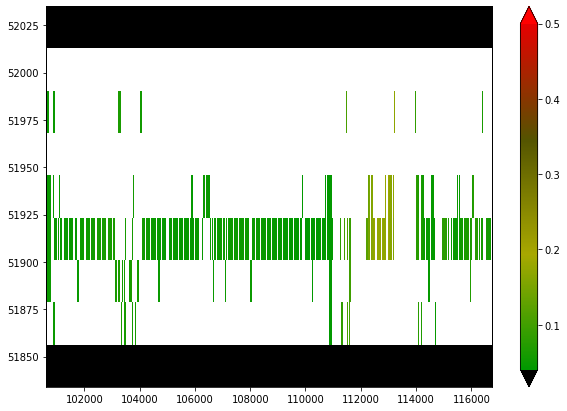

Mean value of metrics: 0.0652


In [145]:
metrics = pipeline.v('metrics1')
mean_metrics = metrics.evaluate('map', bin_size=40, figsize=(10, 7), save_dir=None, pad=True, max_value=0.5)
print('Mean value of metrics: {:.3}'.format(mean_metrics))